In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from utils import *
from model import * 
from matplotlib.colors import ListedColormap

In [2]:
import importlib
import utils 
importlib.reload(utils)
from utils import *

In [3]:
def convert_params(params): 
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    B = np.diagflat([params[5]**2, gamma])
    Dh = B[0, 0] 
    B[1, 0] += c*Dh
    B[0, 1] = B[1, 0] 
    B[1, 1] += c*c*Dh
    return J, B 

def get_J(params):
    c = params[3]
    gamma = params[1]
    J = np.array([[-params[0], params[2]], [-c*params[0], -gamma+c*params[2]]])
    return J 
    

def flow(coor): 
    rhs = np.einsum('ij,jkl->ikl', J, coor)
    rhs[1] -= beta*coor[1]**3 
    return rhs

In [11]:
# define a custom class with a different order of the nonlinear term 

class FHN_higher_order_nonlinear(FHN_det): 

    def _rhs(self, t, y): 
            rhs = self.J @ y 
            rhs[1] -= self.b*y[1]**7
            return rhs

In [12]:
# simulation parameter 
dt = 5e-3
n_frames = 5000
T = 0.033*n_frames
n_repeats = 1

# # estimation from spinning rod + direct measurements 
gamma = 1
c =  15.5*gamma
mu = 0.09
epsilon = 0.35
beta = 15.0*gamma
sigma = np.sqrt(epsilon)*0.052

params = [epsilon, gamma, mu, c, beta, sigma]

# MLE 

# params = [0.09872, 0.42583, 0.18864, 5.78463, 12.51193, 0.02366]

print(params)
J, B = convert_params(params)
print('J: ', J)
print('B: ', B)
print('eigenvals: ', np.linalg.eigvals(J))


m = FHN_det(params, get_J)
det_res = m.evolve(T, n_frames, [0.1, 0])

[0.35, 1, 0.09, 15.5, 15.0, 0.030763614872118]
J:  [[-0.35   0.09 ]
 [-5.425  0.395]]
B:  [[9.4640000e-04 1.4669200e-02]
 [1.4669200e-02 1.2273726e+00]]
eigenvals:  [0.0225+0.59117996j 0.0225-0.59117996j]


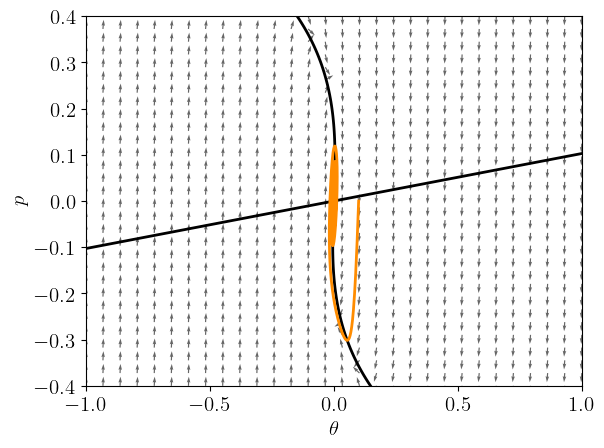

In [13]:
## Plot flow diagrams for decay regime and limit cycle  regime 
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

gamma = params[1]
c = params[3]
mu = params[2] 
beta = params[-2]
epsilon = params[0]

xlim = 1
ylim = 0.4


x = np.linspace(-xlim, xlim, 30)
y = np.linspace(-0.4, 0.4, 30)
X, Y = np.meshgrid(x, y)
coor = np.stack([X, Y], axis=0)

x = np.linspace(-xlim, xlim, 100)
y = np.linspace(-0.4, 0.4, 100)

v = flow(coor)
v /= np.linalg.norm(v, axis=0)


plt.quiver(X, Y, v[0], v[1], alpha=0.6)
plt.plot(((-gamma + c*mu)*y - beta*y**3)/(c*epsilon), y, c='k')
plt.plot(x, mu*y/epsilon, c='k')
plt.plot(det_res[0], det_res[1], c='DarkOrange')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p$')
plt.xlim([x[0], x[-1]])
plt.ylim([y[0], y[-1]])
# plt.savefig('Figures/FHN2.pdf')
plt.show() 

In [14]:
mean = params 
std_err = [0.1*epsilon, 0.1*gamma, 0.05*mu, 0.15*c, 0.15*beta, sigma*0.3]

dt = 1.1e-3 
n_repeats = 1
n_samples = 100

results = [] 
for i in range(n_samples):
    params = np.random.normal(mean, std_err) 
    m = FHN(params, convert_params, m_err = [0.002, 0.04])
    results.extend(m.evolve(T, dt, int(n_frames), n_repeats))

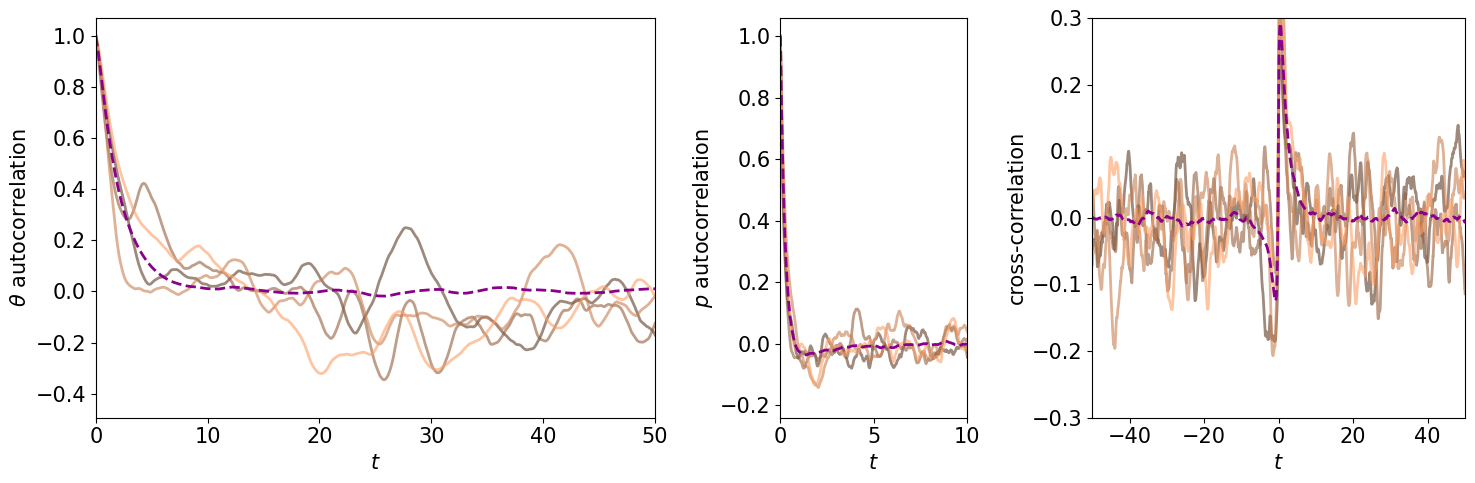

In [15]:
plt.rcParams.update({'lines.linewidth': 2})
plt.rc('text', usetex=False)
plt.rc('font', family='sans serif', size=15)
_, _, cc = plot_corr(results, 3000, 3.3e-2, tex=True, n_trajs=4, colors=['copper', 'darkmagenta'])
plt.ylim([-0.3, 0.3])
plt.savefig('Figures/p7_coor.pdf')
plt.show() 

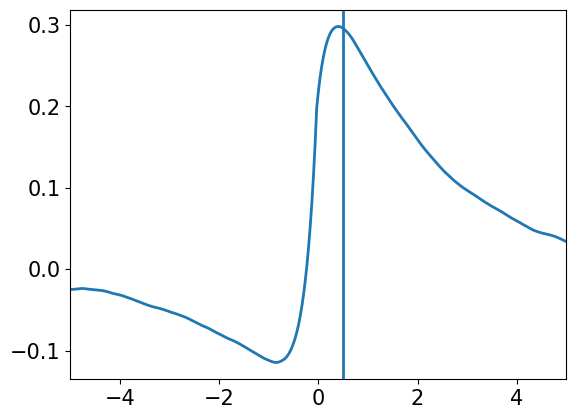

In [10]:
N = 3000 
L = len(results[0][0])
dt = 3.3e-2 
t1 = dt*np.arange(-N+1, N)

plt.plot(t1, np.mean(cc, axis=0)[L-N+1:L+N])
plt.axvline(x=0.5)
plt.xlim([-5, 5])
plt.show() 

In [ ]:
N = 3000 
L = len(results[0][0])
t1 = dt*np.arange(-N+1, N)

plt.plot(t1, np.mean(cc, axis=0)[L-N+1:L+N])
plt.axvline(x=0.5)
plt.xlim([-5, 5])
plt.show() 

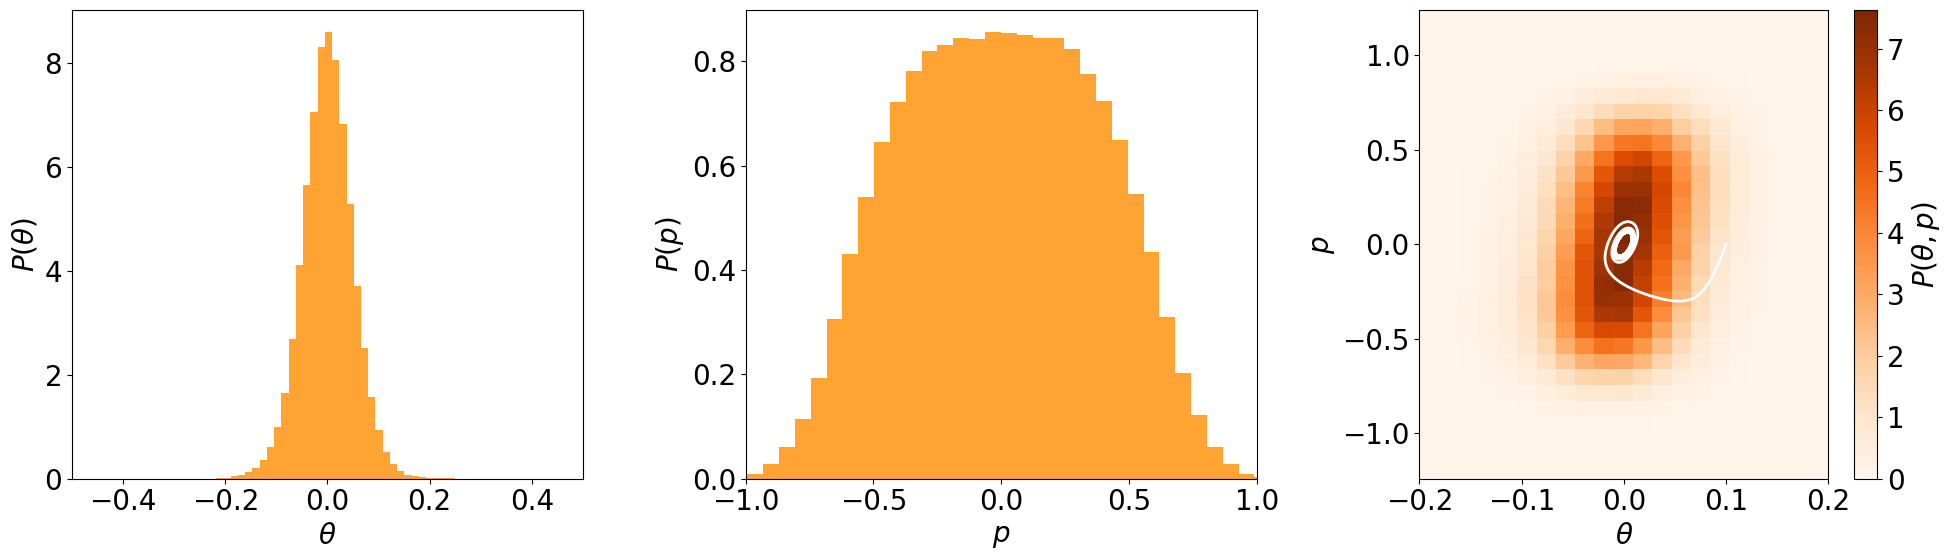

In [7]:
fig, axes = plot_overall_dist(results, tex=False, cmap='Oranges')
axes[2].plot(det_res[0], det_res[1], color='white', linewidth=2)
axes[2].set_xlim([-0.2, 0.2])
plt.savefig('Figures/guess_dist.pdf')
plt.show() 

In [52]:
def plot_corr2(data, N, dt, label, c, norm=True): 
    
    t = dt*np.arange(N)
    t1 = dt*np.arange(-N+1, N)
    L = len(data[0][0])
    
    cross_corrs = [] 
    
    for (theta, p) in data: 
        cross_corrs.append(find_corr(theta, p, norm=norm))

    plt.plot(t1, np.mean(cross_corrs, axis=0)[L-N+1:L+N], label=label, color=c)

In [53]:
collected_results = [] 

cs = [0, 0.1, 1, 15.5, 100]
for temp in cs: 
    
    params = [epsilon, gamma, mu, temp, beta, sigma]

    n_repeats = 5
    print(params)
    m = FHN(params, convert_params)
    collected_results.append(m.evolve(T, dt, int(n_frames), n_repeats))

[0.35, 1, 0.09, 0, 15.0, 0.030763614872118]
[0.35, 1, 0.09, 0.1, 15.0, 0.030763614872118]
[0.35, 1, 0.09, 1, 15.0, 0.030763614872118]
[0.35, 1, 0.09, 15.5, 15.0, 0.030763614872118]
[0.35, 1, 0.09, 100, 15.0, 0.030763614872118]


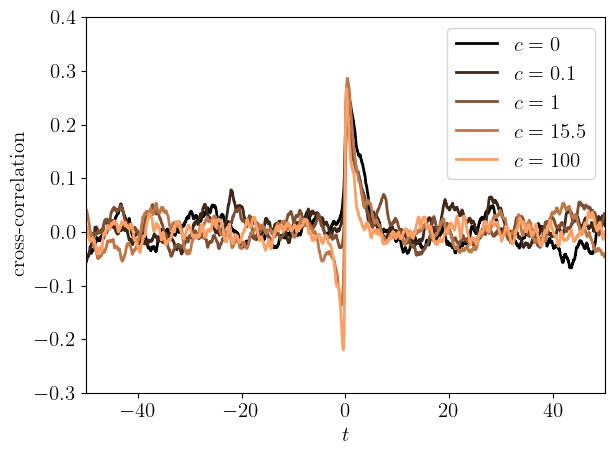

In [54]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

cmap = plt.colormaps['copper']

for (i, (temp, results)) in enumerate(zip(cs, collected_results)): 
    plot_corr2(results, 3000, 3.3e-2, r'$c = {{{}}}$'.format(temp), c=cmap(i/5))

    
plt.ylabel(r'cross-correlation')
plt.xlabel(r'$t$')
plt.xlim([-50, 50])
plt.ylim([-0.3, 0.4])
plt.legend() 
plt.tight_layout()
plt.savefig('Figures/c_variations.pdf')
plt.show() 

In [55]:
collected_results = [] 

mus = [0, 1e-2, 0.09, 1, 10]
for temp in mus: 
    
    params = [epsilon, gamma, temp, c, beta, 0.044]

    n_repeats = 5
    print(params)
    m = FHN(params, convert_params)
    collected_results.append(m.evolve(T, dt, int(n_frames), n_repeats))

[0.35, 1, 0, 15.5, 15.0, 0.044]
[0.35, 1, 0.01, 15.5, 15.0, 0.044]
[0.35, 1, 0.09, 15.5, 15.0, 0.044]
[0.35, 1, 1, 15.5, 15.0, 0.044]
[0.35, 1, 10, 15.5, 15.0, 0.044]


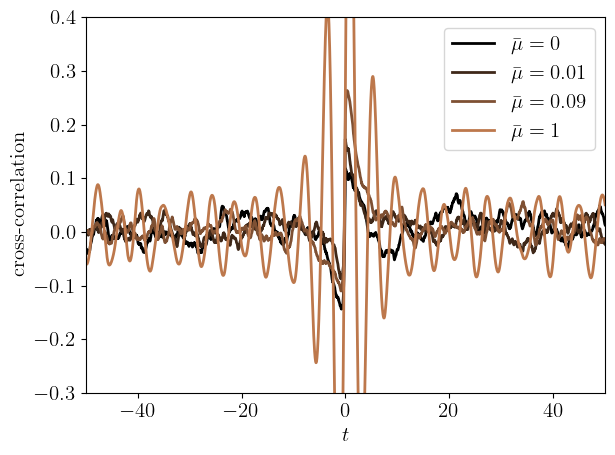

In [66]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)

cmap = plt.colormaps['copper']

for (i, (temp, results)) in enumerate(zip(mus[:4], collected_results[:4])): 
    plot_corr2(results, 3000, 3.3e-2, r'$\bar{{\mu}} = {{{}}}$'.format(temp), c=cmap(i/5))

plt.ylabel(r'cross-correlation')
plt.xlabel(r'$t$')
plt.xlim([-50, 50])
plt.ylim([-0.3, 0.4])
plt.legend() 
plt.tight_layout()
plt.savefig('Figures/mu_variations.pdf')
plt.show() 